<a href="https://colab.research.google.com/github/joaochenriques/HydroFit/blob/main/Fit_V02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
import matplotlib.pyplot as mpl
import numpy as np
from scipy.optimize import curve_fit
from dataclasses import dataclass

import pathlib, subprocess, os
import pandas as pd

def cmdcall( cmd, verbose=True ):
    output = subprocess.getoutput( cmd )
    if verbose: print(output)

In [89]:
if not pathlib.Path("mpl_utils.py").exists():
    cmdcall( "curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py" )

import mpl_utils as mut
mut.config_plots()

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

from IPython.display import display, clear_output

In [90]:
summary = { 'Data': [], 'HAMS': [], 'WAMIT': [] }

def AppendToSummary( label, val_H, val_W ):
    if label in summary['Data']:
        i = summary['Data'].index( label )
        summary['HAMS'][i] = val_H
        summary['WAMIT'][i] = val_W
    else:
        summary['Data'].append( label )
        summary['HAMS'].append( val_H )
        summary['WAMIT'].append( val_W )

In [91]:
def normalize( x ):
    m = np.max(x)
    return x / m, m

def characteristic_length( x ):
    return normalize( 1.0 / np.sqrt( x ) )[0]
    # return normalize( 1.0 / x )[0]

def fit_func( x, ϕ0, α, p ):
    return ϕ0 + α * x**p

@dataclass
class data_test:
    filename: str
    label: str
    solver: str
    i0: int
    range: tuple

In [92]:
cmdcall( 'curl -O https://raw.githubusercontent.com/joaochenriques/HydroFit/main/DeltaWind.zip' )
cmdcall( 'unzip DeltaWind.zip' )

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  4318  100  4318    0     0  15986      0 --:--:-- --:--:-- --:--:-- 15992
Archive:  DeltaWind.zip
replace DeltaWind HAMS_Ainf(3,3).csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


In [139]:
DeltaWind_data_lst = [
    data_test( 'DeltaWind HAMS_Ainf(3,3).csv',  '$A^\\infty_{33}$ [kg]', 'HAMS',  1, (2.4E7, 3.0E7, 7) ),
    data_test( 'DeltaWind WAMIT_Ainf(3,3).csv', '$A^\\infty_{33}$ [kg]', 'WAMIT', 1, (2.4E7, 3.0E7, 7) ),
#
    data_test( 'DeltaWind HAMS_B(3,3,1.00 rad_s).csv',  '$B_{33}$ [kg/s]', 'HAMS',  1, (6.5E5, 9E5, 6 ) ),
    data_test( 'DeltaWind WAMIT_B(3,3,1.00 rad_s).csv', '$B_{33}$ [kg/s]', 'WAMIT', 1, (6.5E5, 9E5, 6 ) ),
#
    data_test( 'DeltaWind HAMS_C(3,3).csv',  '$C_{33}$ [kg/s$^2$]', 'HAMS',  1, ( 4.84E6, 5E6, 6 ) ),
    data_test( 'DeltaWind WAMIT_C(3,3).csv', '$C_{33}$ [kg/s$^2$]', 'WAMIT', 1, ( 4.84E6, 5E6, 6 ) ),
]

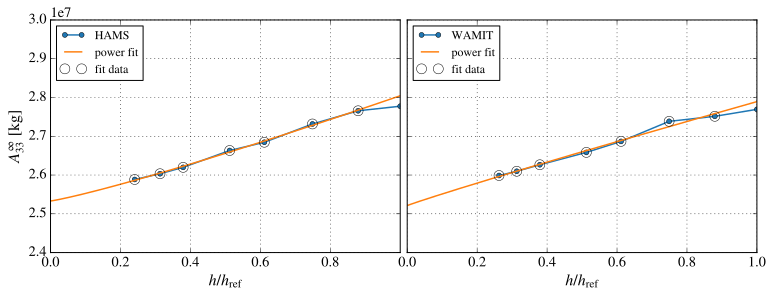

In [140]:
fig, (ax1, ax2) = mpl.subplots(1,2, figsize=(12, 4) )
fig.subplots_adjust( wspace = 0.02 )

data = DeltaWind_data_lst[0]
df = pd.read_csv( data.filename, skiprows=[0,1], header=None, sep=';' )

h = characteristic_length( np.array( df[0] ) )
u, u_max_H = normalize( np.array( df[1] ) )

popt_H, _ = curve_fit(fit_func, h[data.i0:], u[data.i0:] )

h0 = np.linspace( 0.0, 1.0, 500 )
y0 = fit_func( h0, *popt_H )

ax1.plot( h, u*u_max_H, 'o-', label=data.solver )
ax1.plot( h0, y0*u_max_H, '-', label='power fit' )
ax1.plot( h[data.i0:], u[data.i0:]*u_max_H, 'o', label='fit data', markerfacecolor='none', markersize=10 )

ax1.legend( loc='upper left', fontsize=12 )
ax1.yaxis.set_ticks( np.linspace( *data.range ) )
ax1.set_ylim( data.range[0:2] )
ax1.set_xlabel( '$h/h_\mathrm{ref}$')
ax1.set_ylabel( data.label )
ax1.grid()
ax1.set_xticks( ax1.get_xticks()[0:-1] )

data = DeltaWind_data_lst[1]
df = pd.read_csv( data.filename, skiprows=[0,1], header=None, sep=';' )

h = characteristic_length( np.array( df[0] ) )
u, u_max_W = normalize( np.array( df[1] ) )

popt_W, _ = curve_fit(fit_func, h[data.i0:], u[data.i0:], p0=popt_H )

h0 = np.linspace( 0.0, 1.0, 500 )
y0 = fit_func( h0, *popt_W )

ax2.plot( h, u*u_max_W, 'o-', label=data.solver )
ax2.plot( h0, y0*u_max_W, '-', label='power fit' )
ax2.plot( h[data.i0:], u[data.i0:]*u_max_W, 'o', label='fit data', markerfacecolor='none', markersize=10 )

ax2.legend( loc='upper left', fontsize=12 )
ax2.set_ylim( data.range[0:2] )
ax2.yaxis.set_ticks( np.linspace( *data.range ) )
ax2.set_xlabel( '$h/h_\mathrm{ref}$' )
ax2.grid()
ax2.yaxis.set_ticklabels([])
mpl.savefig( 'A33.jpg', bbox_inches='tight', pad_inches=0.02 )

AppendToSummary( 'DeltaWind Ainf', popt_H[0]*u_max_H, popt_W[0]*u_max_W )

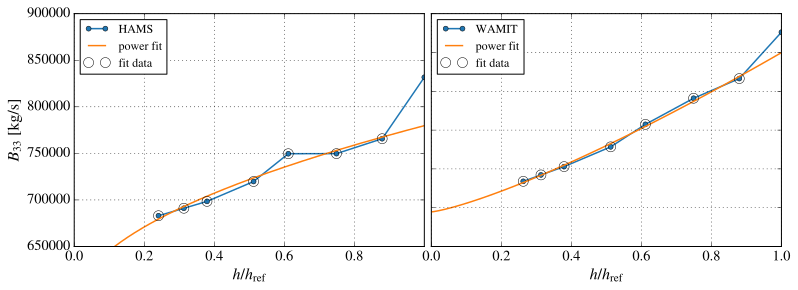

In [141]:
fig, (ax1, ax2) = mpl.subplots(1,2, figsize=(12, 4) )
fig.subplots_adjust( wspace = 0.02 )


data = DeltaWind_data_lst[2]
df = pd.read_csv( data.filename, skiprows=[0,1], header=None, sep=';' )

h = characteristic_length( np.array( df[0] ) )
u, u_max_H = normalize( np.array( df[1] ) )

popt_H, _ = curve_fit(fit_func, h[data.i0:], u[data.i0:] )

h0 = np.linspace( 0.0, 1.0, 500 )
y0 = fit_func( h0, *popt_H )

ax1.plot( h, u*u_max_H, 'o-', label=data.solver )
ax1.plot( h0, y0*u_max_H, '-', label='power fit' )
ax1.plot( h[data.i0:], u[data.i0:]*u_max_H, 'o', label='fit data', markerfacecolor='none', markersize=10 )

ax1.legend( loc='upper left', fontsize=12 )
ax1.yaxis.set_ticks( np.linspace( *data.range, endpoint=True ) )
ax1.set_ylim( data.range[0:2] )
ax1.set_xlabel( '$h/h_\mathrm{ref}$')
ax1.set_ylabel( data.label )
ax1.grid()
ax1.set_xticks( ax1.get_xticks()[0:-1] )

data = DeltaWind_data_lst[3]
df = pd.read_csv( data.filename, skiprows=[0,1], header=None, sep=';' )

h = characteristic_length( np.array( df[0] ) )
u, u_max_W = normalize( np.array( df[1] ) )

popt_W, _ = curve_fit(fit_func, h[data.i0:], u[data.i0:] )

h0 = np.linspace( 0.0, 1.0, 500 )
y0 = fit_func( h0, *popt_W )

ax2.plot( h, u*u_max_W, 'o-', label=data.solver )
ax2.plot( h0, y0*u_max_W, '-', label='power fit' )
ax2.plot( h[data.i0:], u[data.i0:]*u_max_W, 'o', label='fit data', markerfacecolor='none', markersize=10 )

ax2.legend( loc='upper left', fontsize=12 )
ax1.yaxis.set_ticks( np.linspace( *data.range, endpoint=True ) )
ax1.set_ylim( data.range[0:2] )
ax2.set_xlabel( '$h/h_\mathrm{ref}$' )
ax2.grid()
ax2.yaxis.set_ticklabels([])
mpl.savefig( 'B33.jpg', bbox_inches='tight', pad_inches=0.02 )

AppendToSummary( 'DeltaWind B', popt_H[0]*u_max_H, popt_W[0]*u_max_W )

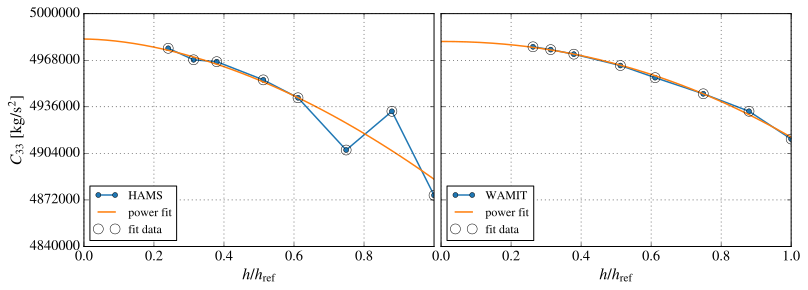

In [129]:
fig, (ax1, ax2) = mpl.subplots(1,2, figsize=(12, 4) )
fig.subplots_adjust( wspace = 0.02 )


data = DeltaWind_data_lst[4]
df = pd.read_csv( data.filename, skiprows=[0,1], header=None, sep=';' )

h = characteristic_length( np.array( df[0] ) )
u, u_max_H = normalize( np.array( df[1] ) )

popt_H, _ = curve_fit(fit_func, h[data.i0:], u[data.i0:] )

h0 = np.linspace( 0.0, 1.0, 500 )
y0 = fit_func( h0, *popt_H )

ax1.plot( h, u*u_max_H, 'o-', label=data.solver )
ax1.plot( h0, y0*u_max_H, '-', label='power fit' )
ax1.plot( h[data.i0:], u[data.i0:]*u_max_H, 'o', label='fit data', markerfacecolor='none', markersize=10 )

ax1.legend( loc='lower left', fontsize=12 )
ax1.yaxis.set_ticks( np.linspace( *data.range, endpoint=True ) )
ax1.set_ylim( data.range[0:2] )
ax1.set_xlabel( '$h/h_\mathrm{ref}$')
ax1.set_ylabel( data.label )
ax1.grid()
ax1.set_xticks( ax1.get_xticks()[0:-1] )

data = DeltaWind_data_lst[5]
df = pd.read_csv( data.filename, skiprows=[0,1], header=None, sep=';' )

h = characteristic_length( np.array( df[0] ) )
u, u_max_W = normalize( np.array( df[1] ) )

popt_W, _ = curve_fit(fit_func, h[data.i0:], u[data.i0:] )

h0 = np.linspace( 0.0, 1.0, 500 )
y0 = fit_func( h0, *popt_W )

ax2.plot( h, u*u_max_W, 'o-', label=data.solver )
ax2.plot( h0, y0*u_max_W, '-', label='power fit' )
ax2.plot( h[data.i0:], u[data.i0:]*u_max_W, 'o', label='fit data', markerfacecolor='none', markersize=10 )

ax2.legend( loc='lower left', fontsize=12 )
ax2.yaxis.set_ticks( np.linspace( *data.range, endpoint=True ) )
ax2.set_ylim( data.range[0:2] )
ax2.set_xlabel( '$h/h_\mathrm{ref}$' )
ax2.grid()
ax2.yaxis.set_ticklabels([])
mpl.savefig( 'C33.jpg', bbox_inches='tight', pad_inches=0.02 )

AppendToSummary( 'DeltaWind C', popt_H[0]*u_max_H, popt_W[0]*u_max_W )

In [130]:
cmdcall( 'curl -O https://raw.githubusercontent.com/joaochenriques/HydroFit/main/Roro.zip' )
cmdcall( 'unzip Roro.zip' )

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  4039  100  4039    0     0  15940      0 --:--:-- --:--:-- --:--:-- 15901
Archive:  Roro.zip
replace Roro HAMS_Ainf(3,3).csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


In [131]:
Roro_data_lst = [
    data_test( 'Roro HAMS_Ainf(3,3).csv',  '$A^\\infty_{33}$ [kg]', 'HAMS',  0, (1.7E7, 3.2E7, 6) ),
    data_test( 'Roro WAMIT_Ainf(3,3).csv', '$A^\\infty_{33}$ [kg]', 'WAMIT', 0, (1.7E7, 3.2E7, 6) ),
#
    data_test( 'Roro HAMS_B(3,3,1.00 rad_s).csv',  '$B_{33}$ [kg/s]', 'HAMS',  0, (1.48E7, 1.6E7, 7) ),
    data_test( 'Roro WAMIT_B(3,3,1.00 rad_s).csv', '$B_{33}$ [kg/s]', 'WAMIT', 0, (1.48E7, 1.6E7, 7) ),
#
    data_test( 'Roro HAMS_C(3,3).csv',  '$C_{33}$ [kg/s$^2$]', 'HAMS',  0, (3.26E7, 3.268E7, 5) ),
    data_test( 'Roro WAMIT_C(3,3).csv', '$C_{33}$ [kg/s$^2$]', 'WAMIT', 0, (3.26E7, 3.268E7, 5) ),
]

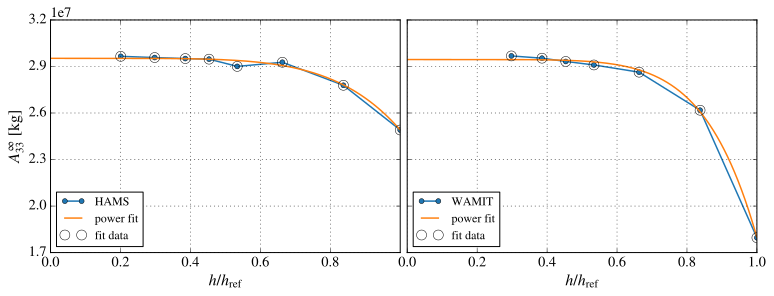

In [132]:
fig, (ax1, ax2) = mpl.subplots(1,2, figsize=(12, 4) )
fig.subplots_adjust( wspace = 0.02 )


data = Roro_data_lst[0]
df = pd.read_csv( data.filename, skiprows=[0,1], header=None, sep=';' )

h = characteristic_length( np.array( df[0] ) )
u, u_max_H = normalize( np.array( df[1] ) )

popt_H, cov_H = curve_fit(fit_func, h[data.i0:], u[data.i0:] )

h0 = np.linspace( 0.0, 1.0, 500 )
y0 = fit_func( h0, *popt_H )

ax1.plot( h, u*u_max_H, 'o-', label=data.solver )
ax1.plot( h0, y0*u_max_H, '-', label='power fit' )
ax1.plot( h[data.i0:], u[data.i0:]*u_max_H, 'o', label='fit data', markerfacecolor='none', markersize=10 )

ax1.legend( loc='lower left', fontsize=12 )
ax1.yaxis.set_ticks( np.linspace( *data.range, endpoint=True ) )
ax1.set_ylim( data.range[0:2] )
ax1.set_xlabel( '$h/h_\mathrm{ref}$')
ax1.set_ylabel( data.label )
ax1.grid()
ax1.set_xticks( ax1.get_xticks()[0:-1] )

data = Roro_data_lst[1]
df = pd.read_csv( data.filename, skiprows=[0,1], header=None, sep=';' )

h = characteristic_length( np.array( df[0] ) )
u, u_max_W = normalize( np.array( df[1] ) )

popt_W, cov_W = curve_fit(fit_func, h[data.i0:], u[data.i0:], p0=popt_H )

h0 = np.linspace( 0.0, 1.0, 500 )
y0 = fit_func( h0, *popt_W )

ax2.plot( h, u*u_max_W, 'o-', label=data.solver )
ax2.plot( h0, y0*u_max_W, '-', label='power fit' )
ax2.plot( h[data.i0:], u[data.i0:]*u_max_W, 'o', label='fit data', markerfacecolor='none', markersize=10 )

ax2.legend( loc='lower left', fontsize=12 )
ax2.yaxis.set_ticks( np.linspace( *data.range, endpoint=True ) )
ax2.set_ylim( data.range[0:2] )
ax2.set_xlabel( '$h/h_\mathrm{ref}$' )
ax2.grid()
ax2.yaxis.set_ticklabels([])
mpl.savefig( 'A33.jpg', bbox_inches='tight', pad_inches=0.02 )

AppendToSummary( 'Ro-Ro Ainf', popt_H[0]*u_max_H, popt_W[0]*u_max_W )

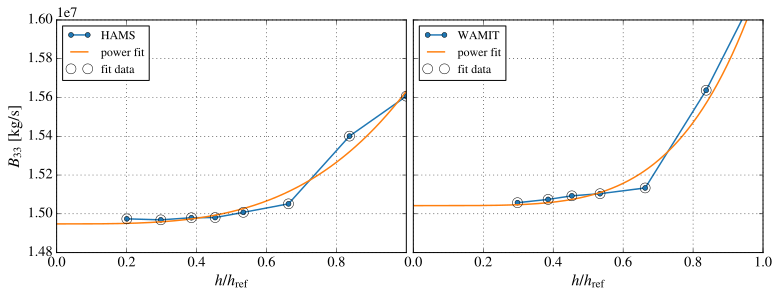

In [133]:
fig, (ax1, ax2) = mpl.subplots(1,2, figsize=(12, 4) )
fig.subplots_adjust( wspace = 0.02 )


data = Roro_data_lst[2]
df = pd.read_csv( data.filename, skiprows=[0,1], header=None, sep=';' )

h = characteristic_length( np.array( df[0] ) )
u, u_max_H = normalize( np.array( df[1] ) )

popt_H, _ = curve_fit(fit_func, h[data.i0:], u[data.i0:] )

h0 = np.linspace( 0.0, 1.0, 500 )
y0 = fit_func( h0, *popt_H )

ax1.plot( h, u*u_max_H, 'o-', label=data.solver )
ax1.plot( h0, y0*u_max_H, '-', label='power fit' )
ax1.plot( h[data.i0:], u[data.i0:]*u_max_H, 'o', label='fit data', markerfacecolor='none', markersize=10 )

ax1.legend( loc='upper left', fontsize=12 )
ax1.yaxis.set_ticks( np.linspace( *data.range, endpoint=True ) )
ax1.set_ylim( data.range[0:2] )
ax1.set_xlabel( '$h/h_\mathrm{ref}$')
ax1.set_ylabel( data.label )
ax1.grid()
ax1.set_xticks( ax1.get_xticks()[0:-1] )

data = Roro_data_lst[3]
df = pd.read_csv( data.filename, skiprows=[0,1], header=None, sep=';' )

h = characteristic_length( np.array( df[0] ) )
u, u_max_W = normalize( np.array( df[1] ) )

popt_W, _ = curve_fit(fit_func, h[data.i0:], u[data.i0:] )

h0 = np.linspace( 0.0, 1.0, 500 )
y0 = fit_func( h0, *popt_W )

ax2.plot( h, u*u_max_W, 'o-', label=data.solver )
ax2.plot( h0, y0*u_max_W, '-', label='power fit' )
ax2.plot( h[data.i0:], u[data.i0:]*u_max_W, 'o', label='fit data', markerfacecolor='none', markersize=10 )

ax2.legend( loc='upper left', fontsize=12 )
ax2.yaxis.set_ticks( np.linspace( *data.range, endpoint=True ) )
ax2.set_ylim( data.range[0:2] )
ax2.set_xlabel( '$h/h_\mathrm{ref}$' )
ax2.grid()
ax2.yaxis.set_ticklabels([])
mpl.savefig( 'B33.jpg', bbox_inches='tight', pad_inches=0.02 )

AppendToSummary( 'Ro-Ro B', popt_H[0]*u_max_H, popt_W[0]*u_max_W )

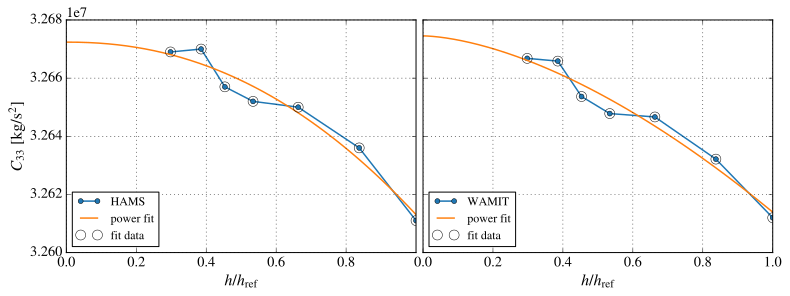

In [134]:
fig, (ax1, ax2) = mpl.subplots(1,2, figsize=(12, 4) )
fig.subplots_adjust( wspace = 0.02 )


data = Roro_data_lst[4]
df = pd.read_csv( data.filename, skiprows=[0,1], header=None, sep=';' )

h = characteristic_length( np.array( df[0] )[0:-1] )
u, u_max_H = normalize( np.array( df[1] )[0:-1] )

popt_H, _ = curve_fit(fit_func, h[data.i0:], u[data.i0:] )

h0 = np.linspace( 0.0, 1.0, 500 )
y0 = fit_func( h0, *popt_H )

ax1.plot( h, u*u_max_H, 'o-', label=data.solver )
ax1.plot( h0, y0*u_max_H, '-', label='power fit' )
ax1.plot( h[data.i0:], u[data.i0:]*u_max_H, 'o', label='fit data', markerfacecolor='none', markersize=10 )

ax1.legend( loc='lower left', fontsize=12 )
ax1.yaxis.set_ticks( np.linspace( *data.range, endpoint=True ) )
ax1.set_ylim( data.range[0:2] )
ax1.set_xlabel( '$h/h_\mathrm{ref}$')
ax1.set_ylabel( data.label )
ax1.grid()
ax1.set_xticks( ax1.get_xticks()[0:-1] )

data = Roro_data_lst[5]
df = pd.read_csv( data.filename, skiprows=[0,1], header=None, sep=';' )

h = characteristic_length( np.array( df[0] ) )
u, u_max_W = normalize( np.array( df[1] ) )

popt_W, _ = curve_fit(fit_func, h[data.i0:], u[data.i0:] )

h0 = np.linspace( 0.0, 1.0, 500 )
y0 = fit_func( h0, *popt_W )

ax2.plot( h, u*u_max_W, 'o-', label=data.solver )
ax2.plot( h0, y0*u_max_W, '-', label='power fit' )
ax2.plot( h[data.i0:], u[data.i0:]*u_max_W, 'o', label='fit data', markerfacecolor='none', markersize=10 )

ax2.legend( loc='lower left', fontsize=12 )
ax2.yaxis.set_ticks( np.linspace( *data.range, endpoint=True ) )
ax2.set_ylim( data.range[0:2] )
ax2.set_xlabel( '$h/h_\mathrm{ref}$' )
ax2.grid()
ax2.yaxis.set_ticklabels([])
mpl.savefig( 'C33.jpg', bbox_inches='tight', pad_inches=0.02 )

AppendToSummary( 'Ro-Ro C', popt_H[0]*u_max_H, popt_W[0]*u_max_W )

In [135]:
df_summary = pd.DataFrame( summary )
df_summary

,Data,HAMS,WAMIT
0,DeltaWind Ainf,2.487207e+07,2.464755e+07
1,DeltaWind B,6.783997e+05,6.656311e+05
2,DeltaWind C,4.982559e+06,4.980892e+06
3,Ro-Ro Ainf,2.952597e+07,2.944855e+07
4,Ro-Ro B,1.494786e+07,1.504212e+07
5,Ro-Ro C,3.267238e+07,3.267453e+07
